In [1]:
import pandas as pd
import numpy as np
from datasets import Dataset, DatasetDict

In [2]:
pf = pd.read_json("../data/data_non.json")

In [3]:
print(pf.head())

   Consumed Power (W)  Produced Power (W)     Gb(i)     Gd(i)     H_sun  \
0             63239.1          3840.46609  0.000000  0.000000  0.000000   
1             61292.5          3840.46509  0.000000  0.000000  0.000000   
2             61249.6          3840.45602  0.000000  0.000000  0.000000   
3             61852.0          3840.45472  0.000000  0.000000  0.000000   
4            120076.0          3840.45837  0.308026  0.267709  0.155976   

        T2m                date  
0  0.728788 2018-08-01 01:10:00  
1  0.713805 2018-08-01 02:10:00  
2  0.702694 2018-08-01 03:10:00  
3  0.694108 2018-08-01 04:10:00  
4  0.702020 2018-08-01 05:10:00  


In [4]:
produced = pf.loc[:, ["Produced Power (W)", "date"]]
consumed = pf.loc[:, ["Consumed Power (W)", "date"]]

print(consumed.head())

   Consumed Power (W)                date
0             63239.1 2018-08-01 01:10:00
1             61292.5 2018-08-01 02:10:00
2             61249.6 2018-08-01 03:10:00
3             61852.0 2018-08-01 04:10:00
4            120076.0 2018-08-01 05:10:00


In [5]:
time_series_produced = produced.to_numpy()
print(time_series_produced)

[[3840.46609 Timestamp('2018-08-01 01:10:00')]
 [3840.46509 Timestamp('2018-08-01 02:10:00')]
 [3840.45602 Timestamp('2018-08-01 03:10:00')]
 ...
 [3805.6699 Timestamp('2019-07-31 22:10:00')]
 [3806.2449 Timestamp('2019-07-31 23:10:00')]
 [3805.9619 Timestamp('2019-08-01 00:10:00')]]


### create dataset

In [6]:
num_days = 10
freq = 1
sequence_length = num_days * freq * 24

#prepare the sequences
sequences = []
time_start = []

for i in range(0, len(time_series_produced) - sequence_length + 1, 12):
    #print(time_series_produced[i:i+sequence_length])
    sequences.append(time_series_produced[i:i+sequence_length])    

print("Total number of sequences: ", len(sequences))
print("Length of each sequence: ", len(sequences[0]))
print("Total number of time_start: ", len(time_start))

Total number of sequences:  708
Length of each sequence:  240
Total number of time_start:  0


In [7]:
sequences = np.array(sequences)

In [8]:
# Shuffle the sequences randomly
np.random.shuffle(sequences)

In [9]:
# Define the proportion for train, test, and val sets
train_ratio = 1
test_ratio = 0
val_ratio = 0

# Calculate the sizes of each set
train_size = int(train_ratio * len(sequences))
test_size = int(test_ratio * len(sequences))
val_size = len(sequences) - train_size - test_size

# Split the sequences into train, test, and validation sets
train_sequences = sequences[:train_size]
test_sequences = sequences[:train_size]
val_sequences = sequences[:train_size]
#test_sequences = sequences[train_size:train_size+test_size]
#val_sequences = sequences[train_size+test_size:]

print("Train set shape:", train_sequences.shape)
print("Test set shape:", test_sequences.shape)
print("Validation set shape:", val_sequences.shape)

Train set shape: (708, 240, 2)
Test set shape: (708, 240, 2)
Validation set shape: (708, 240, 2)


In [10]:
def flatten_list(input_list):
  """Flattens a list of lists.

  Args:
    input_list: A list of lists.

  Returns:
    A flattened list.
  """
  new_list = []
  for sublist in input_list:   
    #print("sub", sublist)
    flattened_list = np.array([])
    for item in sublist:
      #print(item)
      flattened_list = np.append(flattened_list, item)
    #print("flat", flattened_list)
    #print("new!", new_list)
    new_list.append(flattened_list)
  return new_list

input_list = [[[0.0171997752],
              [0.0395013388]],
              [[0.1004146707],
              [0.2528682776]],
              [[0.20762656000000002],[0.2528682776]]]

output_list = flatten_list(input_list)

print(type(output_list))

<class 'list'>


In [11]:
leng = train_sequences[:, :, 0:1].shape[1]

data_train = {
    'target': flatten_list(train_sequences[:, :leng-48, 0:1]),
    'start': list(train_sequences[:, 0:1, 1:].flatten()),
    'feat_static_cat': [[i] for i in range(train_sequences.shape[0])],
    'feat_dynamic_real': [None for i in range(train_sequences.shape[0])],
    'item_id': ["T" +str(i)  for i in range(1, train_sequences.shape[0]+1)],
}

data_test = {
    'target': flatten_list(test_sequences[:, :, 0:1]),
    'start': list(train_sequences[:, 0:1, 1:].flatten()),
    'feat_static_cat': [[i] for i in range(train_sequences.shape[0])],
    'feat_dynamic_real': [None for i in range(train_sequences.shape[0])],
    'item_id': ["T" +str(i)  for i in range(1, train_sequences.shape[0]+1)],

}
data_val = {
    'target': flatten_list(val_sequences[:, :leng-24, 0:1]),
    'start': list(train_sequences[:, 0:1, 1:].flatten()),
    'feat_static_cat': [[i] for i in range(train_sequences.shape[0])],
    'feat_dynamic_real': [None for i in range(train_sequences.shape[0])],
    'item_id': ["T" + str(i) for i in range(1,train_sequences.shape[0]+1)],
}


In [12]:
dataset = DatasetDict({'train': Dataset.from_dict(data_train), 'test': Dataset.from_dict(data_test), 'validation': Dataset.from_dict(data_val)})
dataset

DatasetDict({
    train: Dataset({
        features: ['target', 'start', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 708
    })
    test: Dataset({
        features: ['target', 'start', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 708
    })
    validation: Dataset({
        features: ['target', 'start', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 708
    })
})

### Visualization new dataset

for every batch divide into firrst 140 and last things

In [13]:
train_example = dataset['train'][0]
print(train_example)
train_example.keys()

{'target': [3800.8719, 3800.8793, 3800.8101, 3800.6657, 3801.1219, 1353.64, 8002.31, 29815.62, 65655.12, 104169.82, 129791.82, 143631.82, 155510.82, 56351.02, 92161.62, 110918.82, 45971.12, 18137.32, 15370.72, 1208.28, 3799.457, 3799.5768, 3799.201, 3799.4112, 3799.578, 3799.7499, 3799.8911, 3800.1425, 3800.1873, 1333.15, 6813.0, 31667.92, 68618.92, 111152.82, 136221.82, 152142.82, 159212.82, 154109.82, 139637.82, 111996.82, 78293.22, 38683.22, 6676.56, 1282.49, 3799.5863, 3799.8336, 3800.086, 3800.0396, 3800.0492, 3800.4734, 3800.7075, 3800.3601, 3800.6379, 1301.44, 6218.91, 31104.02, 69242.22, 109943.82, 136254.82, 148637.82, 153317.82, 155109.82, 136986.82, 110289.82, 42552.62, 48908.22, 11201.06, 1013.87, 3800.1817, 3800.402, 3800.6486, 3800.6664, 3800.7145, 3801.521, 3801.1647, 3801.1542, 3801.3851, 1363.77, 7705.51, 31127.92, 68677.62, 109134.82, 136717.82, 86117.62, 157485.82, 164767.82, 115927.82, 43110.72, 107625.82, 59141.12, 6727.94, 2289.75, 3799.7524, 3800.2646, 3800.3783,

dict_keys(['target', 'start', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

In [14]:
print(train_example['start'])
print(train_example['target'])

2018-08-10 01:10:00
[3800.8719, 3800.8793, 3800.8101, 3800.6657, 3801.1219, 1353.64, 8002.31, 29815.62, 65655.12, 104169.82, 129791.82, 143631.82, 155510.82, 56351.02, 92161.62, 110918.82, 45971.12, 18137.32, 15370.72, 1208.28, 3799.457, 3799.5768, 3799.201, 3799.4112, 3799.578, 3799.7499, 3799.8911, 3800.1425, 3800.1873, 1333.15, 6813.0, 31667.92, 68618.92, 111152.82, 136221.82, 152142.82, 159212.82, 154109.82, 139637.82, 111996.82, 78293.22, 38683.22, 6676.56, 1282.49, 3799.5863, 3799.8336, 3800.086, 3800.0396, 3800.0492, 3800.4734, 3800.7075, 3800.3601, 3800.6379, 1301.44, 6218.91, 31104.02, 69242.22, 109943.82, 136254.82, 148637.82, 153317.82, 155109.82, 136986.82, 110289.82, 42552.62, 48908.22, 11201.06, 1013.87, 3800.1817, 3800.402, 3800.6486, 3800.6664, 3800.7145, 3801.521, 3801.1647, 3801.1542, 3801.3851, 1363.77, 7705.51, 31127.92, 68677.62, 109134.82, 136717.82, 86117.62, 157485.82, 164767.82, 115927.82, 43110.72, 107625.82, 59141.12, 6727.94, 2289.75, 3799.7524, 3800.2646, 3

In [15]:
validation_example = dataset['validation'][0]
validation_example.keys()

dict_keys(['target', 'start', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

In [16]:
print(validation_example['start'])
print(validation_example['target'])

2018-08-10 01:10:00
[3800.8719, 3800.8793, 3800.8101, 3800.6657, 3801.1219, 1353.64, 8002.31, 29815.62, 65655.12, 104169.82, 129791.82, 143631.82, 155510.82, 56351.02, 92161.62, 110918.82, 45971.12, 18137.32, 15370.72, 1208.28, 3799.457, 3799.5768, 3799.201, 3799.4112, 3799.578, 3799.7499, 3799.8911, 3800.1425, 3800.1873, 1333.15, 6813.0, 31667.92, 68618.92, 111152.82, 136221.82, 152142.82, 159212.82, 154109.82, 139637.82, 111996.82, 78293.22, 38683.22, 6676.56, 1282.49, 3799.5863, 3799.8336, 3800.086, 3800.0396, 3800.0492, 3800.4734, 3800.7075, 3800.3601, 3800.6379, 1301.44, 6218.91, 31104.02, 69242.22, 109943.82, 136254.82, 148637.82, 153317.82, 155109.82, 136986.82, 110289.82, 42552.62, 48908.22, 11201.06, 1013.87, 3800.1817, 3800.402, 3800.6486, 3800.6664, 3800.7145, 3801.521, 3801.1647, 3801.1542, 3801.3851, 1363.77, 7705.51, 31127.92, 68677.62, 109134.82, 136717.82, 86117.62, 157485.82, 164767.82, 115927.82, 43110.72, 107625.82, 59141.12, 6727.94, 2289.75, 3799.7524, 3800.2646, 3

In [17]:
freq = "1H"
prediction_length = 24

print(type(train_example["target"]))

assert len(train_example["target"]) + prediction_length == len(
    validation_example["target"]
)

<class 'list'>


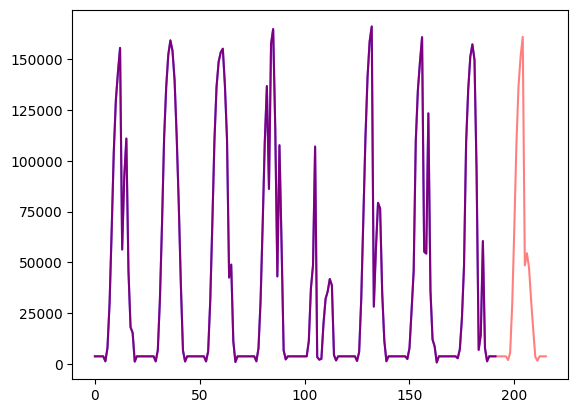

In [18]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots()
axes.plot(train_example["target"], color="blue")
axes.plot(validation_example["target"], color="red", alpha=0.5)

plt.show()

In [19]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [20]:
from functools import lru_cache

import pandas as pd
import numpy as np

@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)

def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch


In [21]:
from functools import partial

train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

In [22]:
from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 23, 24, 25, 47, 48, 49, 71, 72, 73, 95, 96, 97, 119, 120, 121, 143, 144, 145, 167, 168, 169, 335, 336, 337, 503, 504, 505, 671, 672, 673, 719, 720, 721]


In [23]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function hour_of_day at 0x00000285BE5CC790>, <function day_of_week at 0x00000285BE5CC8B0>, <function day_of_month at 0x00000285BE5CC9D0>, <function day_of_year at 0x00000285BE5CCAF0>]


In [24]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,
    # we'll add 2 time features ("month of year" and "age", see further):
    num_time_features=len(time_features) + 1,
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=1,
    # it has 366 possible values:
    cardinality=[len(train_dataset)],
    # the model will learn an embedding of size 2 for each of the 366 possible values:
    embedding_dimension=[2],
    
    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32,
)

model = TimeSeriesTransformerForPrediction(config)

In [25]:
model.config.distribution_output


'student_t'

In [26]:
from gluonts.time_feature import (
    time_features_from_frequency_str,
    TimeFeature,
    get_lags_for_frequency,
)
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

In [27]:
from transformers import PretrainedConfig

def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    # a bit like torchvision.transforms.Compose
    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # month of year in the case when freq="M"
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in its life the value of the time series is,
            # sort of a running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

In [28]:
from gluonts.transform.sampler import InstanceSampler
from typing import Optional

def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )


In [29]:
from typing import Iterable

import torch
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(
        stream, is_train=True
    )
    
    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

In [30]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a Test Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "test")

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)
    
    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [31]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)

In [32]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([256, 769, 5]) torch.FloatTensor
past_values torch.Size([256, 769]) torch.FloatTensor
past_observed_mask torch.Size([256, 769]) torch.FloatTensor
future_time_features torch.Size([256, 24, 5]) torch.FloatTensor
static_categorical_features torch.Size([256, 1]) torch.IntTensor
future_values torch.Size([256, 24]) torch.FloatTensor
future_observed_mask torch.Size([256, 24]) torch.FloatTensor


In [33]:
# perform forward pass
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)

In [34]:
print("Loss:", outputs.loss.item())

Loss: 12.18172836303711


In [ ]:
from accelerate import Accelerator
from torch.optim import AdamW

accelerator = Accelerator()
device = accelerator.device

history = []

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

length_train = len(list(train_dataloader))
model.train()

In [47]:

epochs = 10

for epoch in range(epochs):    
    for idx, batch in enumerate(train_dataloader):        
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        history.append(loss)

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        if idx % 50 == 0:
            print("Epoch: {}/{}.. ".format(epoch, epochs),
                "Batch: {}/{}.. ".format(idx, length_train),
                "Training Loss: {:.3f}.. ".format(loss))    

Epoch: 0/10..  Batch: 0/100..  Training Loss: 8.909.. 
Epoch: 0/10..  Batch: 50/100..  Training Loss: 8.962.. 
Epoch: 1/10..  Batch: 0/100..  Training Loss: 8.921.. 
Epoch: 1/10..  Batch: 50/100..  Training Loss: 8.857.. 
Epoch: 2/10..  Batch: 0/100..  Training Loss: 8.861.. 
Epoch: 2/10..  Batch: 50/100..  Training Loss: 8.861.. 
Epoch: 3/10..  Batch: 0/100..  Training Loss: 8.885.. 
Epoch: 3/10..  Batch: 50/100..  Training Loss: 8.961.. 
Epoch: 4/10..  Batch: 0/100..  Training Loss: 8.825.. 
Epoch: 4/10..  Batch: 50/100..  Training Loss: 8.868.. 
Epoch: 5/10..  Batch: 0/100..  Training Loss: 8.847.. 
Epoch: 5/10..  Batch: 50/100..  Training Loss: 8.868.. 
Epoch: 6/10..  Batch: 0/100..  Training Loss: 8.814.. 
Epoch: 6/10..  Batch: 50/100..  Training Loss: 8.805.. 
Epoch: 7/10..  Batch: 0/100..  Training Loss: 8.878.. 
Epoch: 7/10..  Batch: 50/100..  Training Loss: 8.776.. 
Epoch: 8/10..  Batch: 0/100..  Training Loss: 8.912.. 
Epoch: 8/10..  Batch: 50/100..  Training Loss: 8.831.. 
E

In [48]:
print(type(history))

<class 'list'>


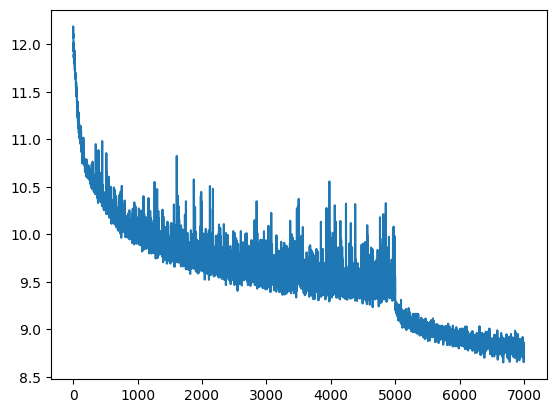

In [49]:
n = np.array([])

for x in history:
    #print(x)
    a = x.data.cpu().numpy()    
    n = np.append(n, a)

plt.plot(n)

In [38]:
model.eval()

forecasts = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())

In [39]:
forecasts[0].shape

(64, 100, 24)

In [40]:
forecasts = np.vstack(forecasts)
print(forecasts.shape)

(708, 100, 24)


In [41]:
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts, 1)

mase_metrics = []
smape_metrics = []
for item_id, ts in enumerate(test_dataset.select(range(10))):

    print(f"item_id: {item_id}")
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id], 
        references=np.array(ground_truth), 
        training=np.array(training_data), 
        periodicity=get_seasonality(freq))
    mase_metrics.append(mase["mase"])
    
    smape = smape_metric.compute(
        predictions=forecast_median[item_id], 
        references=np.array(ground_truth), 
    )
    smape_metrics.append(smape["smape"])

print(f"MASE: {np.mean(mase_metrics)}")

print(f"sMAPE: {np.mean(smape_metrics)}")

item_id: 0
item_id: 1
item_id: 2
item_id: 3
item_id: 4
item_id: 5
item_id: 6
item_id: 7
item_id: 8
item_id: 9
MASE: 1.0302958871856327
sMAPE: 0.3423136931799976


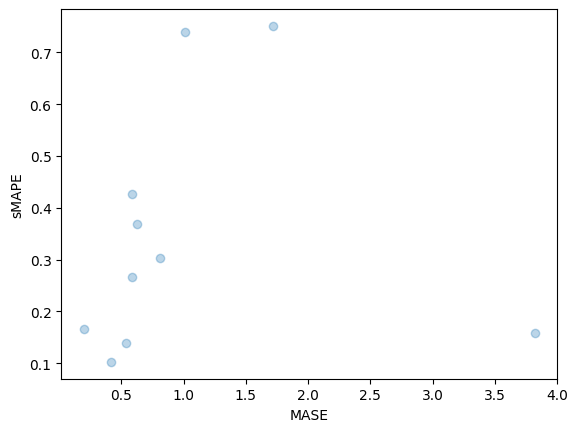

In [42]:
plt.scatter(mase_metrics, smape_metrics, alpha=0.3)
plt.xlabel("MASE")
plt.ylabel("sMAPE")
plt.show()

In [43]:
import matplotlib.dates as mdates

def plot(ts_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=test_dataset[ts_index][FieldName.START],
        periods=len(test_dataset[ts_index][FieldName.TARGET]),
        freq=freq,
    ).to_timestamp()

    # Major ticks every half year, minor ticks every month,
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    ax.plot(
        index[-2*prediction_length:], 
        test_dataset[ts_index]["target"][-2*prediction_length:],
        label="actual",
    )

    plt.plot(
        index[-prediction_length:], 
        np.median(forecasts[ts_index], axis=0),
        label="median",
    )
    
    plt.fill_between(
        index[-prediction_length:],
        forecasts[ts_index].mean(0) - forecasts[ts_index].std(axis=0), 
        forecasts[ts_index].mean(0) + forecasts[ts_index].std(axis=0), 
        alpha=0.3, 
        interpolate=True,
        label="+/- 1-std",
    )
    plt.legend()
    plt.show()

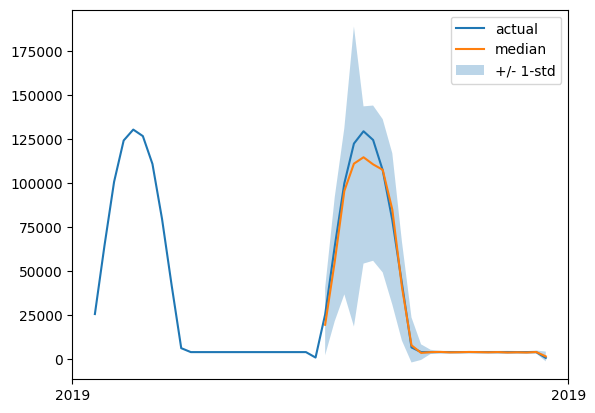

In [44]:
plot(2)

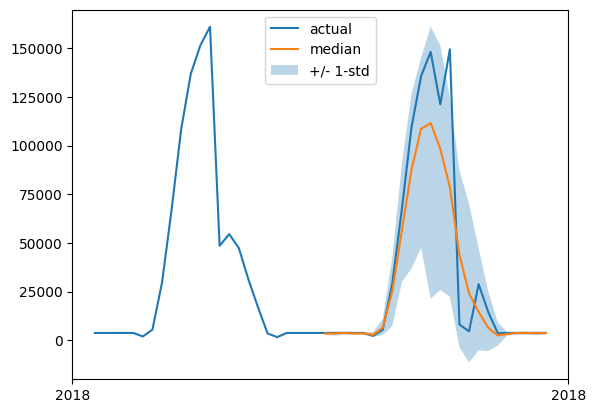

In [45]:
plot(0)